In [1]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import json
import torchtext
import torch.nn as nn
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dataroot = '/Users/stephane/Dropbox/Work/Codes/data/'
datadir = '/Users/stephane/Dropbox/Work/Codes/data/2017-06-custom-intent-engines/'

In [3]:
os.listdir(datadir)

['PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'GetWeather',
 'BookRestaurant',
 'AddToPlaylist',
 'SearchScreeningEvent']

# Exploring the vocabulary

In [2]:
import torchtext
from nltk import word_tokenize
import spacy
 
tokenizer = 'nltk'

if tokenizer == 'spacy':
    from spacy.symbols import ORTH
    my_tok = spacy.load('en')
    my_tok.tokenizer.add_sp
    def tokenize(x):
        return [tok.text for tok in my_tok.tokenizer(x)]
elif tokenizer=='nltk':
    tokenize = word_tokenize
elif tokenizer=='split':
    tokenize = lambda s : s.split(" ")

TEXT   = torchtext.data.Field(lower=True, tokenize=tokenize, sequential=True, batch_first=False)
DELEX  = torchtext.data.Field(lower=True, tokenize=tokenize, sequential=True, batch_first=False)
INTENT = torchtext.data.Field(sequential=False, batch_first=True)

datafields = [("utterance", TEXT), ("labels", None), ("delexicalised", DELEX), ("intent", INTENT)]

trn, vld = torchtext.data.TabularDataset.splits(
               path='.', # the root directory where the data lies
               train='data/train.csv', validation='data/validate.csv',
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=datafields)

In [32]:
from torchtext.data import Iterator, BucketIterator

TEXT.build_vocab(trn, vectors="glove.6B.100d")
DELEX.build_vocab(trn, vectors="glove.6B.100d")
INTENT.build_vocab(trn)

# make iterator for splits
bs=64

train_iter, val_iter = BucketIterator.splits(
    (trn, vld), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(bs, bs),
    device='cpu', # if you want to use the GPU, specify the GPU number here
    sort_key=lambda x: len(x.utterance), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    repeat=False, # we pass repeat=False because we want to wrap this Iterator layer.
)

In [26]:
from embedding import Datasets
datasets = Datasets(train_path='data/train.csv', valid_path='data/validate.csv', emb_dim=100, tokenizer='nltk')
vocab = datasets.TEXT.vocab
i2w = vocab.itos
w2i = vocab.stoi
sos_idx = w2i['SOS']
eos_idx = w2i['EOS']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

In [27]:
for word in i2w:
    if '\n' in word:
        print(word)

In [28]:
w2i['somewhee']

6798

In [37]:
i2w[400:]

['ho',
 'home',
 'hook',
 'horror',
 'image',
 'indicate',
 'inform',
 'insert',
 'international',
 'intrepid',
 'iw',
 'last',
 'late',
 'liked',
 'lists',
 'live',
 'located',
 'lowest',
 'lpaying',
 'mark',
 'maybe',
 'mood',
 'most',
 'move',
 'moved',
 'na',
 'needing',
 'now',
 'number',
 'numbers',
 'oclock',
 'okay',
 'once',
 'opening',
 'opinion',
 'other',
 'our',
 'page',
 'paly',
 'parry',
 'part',
 'perfect',
 'performed',
 'piece',
 'pl',
 'placed',
 'places',
 'plan',
 'plau',
 'playinh',
 'playist',
 'playlists',
 'playlst',
 'plkaying',
 'plpay',
 'plya',
 'plying',
 'plylist',
 'point',
 'prefereably',
 'pretty',
 'provider',
 'quality',
 'rat',
 'recite',
 'records',
 'reestaurant',
 'relaesd',
 'release',
 'require',
 'restarunt',
 'restasurant',
 'restaurantin',
 'restautant',
 'resturant',
 'running',
 'runs',
 'scorching',
 'screening',
 'searves',
 'season',
 'section',
 'selection',
 'selections',
 'sells',
 'send',
 'serve',
 'shoe',
 'shw',
 'slated',
 'soem

In [7]:
print(i2w[462]+'hello')

warmhello


In [8]:
print(DELEX.vocab.stoi['playlist_'])

0


In [164]:
DELEX.vocab.vectors[DELEX.vocab.stoi['the']]

tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.27

In [9]:
INTENT.vocab.itos

['<unk>',
 'AddToPlaylist',
 'BookRestaurant',
 'GetWeather',
 'PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'SearchScreeningEvent']

# Karpathy CharRNN

### Temperature: 0.2

I want to book a reservation for a restaurant for a party of a party of 6 points

I want to book a reservation for a restaurant for a restaurant for a restaurant in Barken Marcha at a party of 6

I need a table for a restaurant for a party of a party of 6 points

### Temperature: 0.5
I need a table for a reservation for a restaurant in the area that serves find movement in the area at a party of a siming from now

I want to half album to Musaf Rock Story Barb playlist.

I want to give this current book The Very Satarora for the twenty-textbook.

### Temperature: 1.0
What will the weather be syar llind in Playlin Man.

Tell it i from the Shawnua Tf Hiss Morny Cimes

Hadon in a top-fight?

play the song from the fifties for ten in Mondital Maker

# Analyzing the runs

In [42]:
import torch
run = torch.load('run.pyT')

# Dynamics

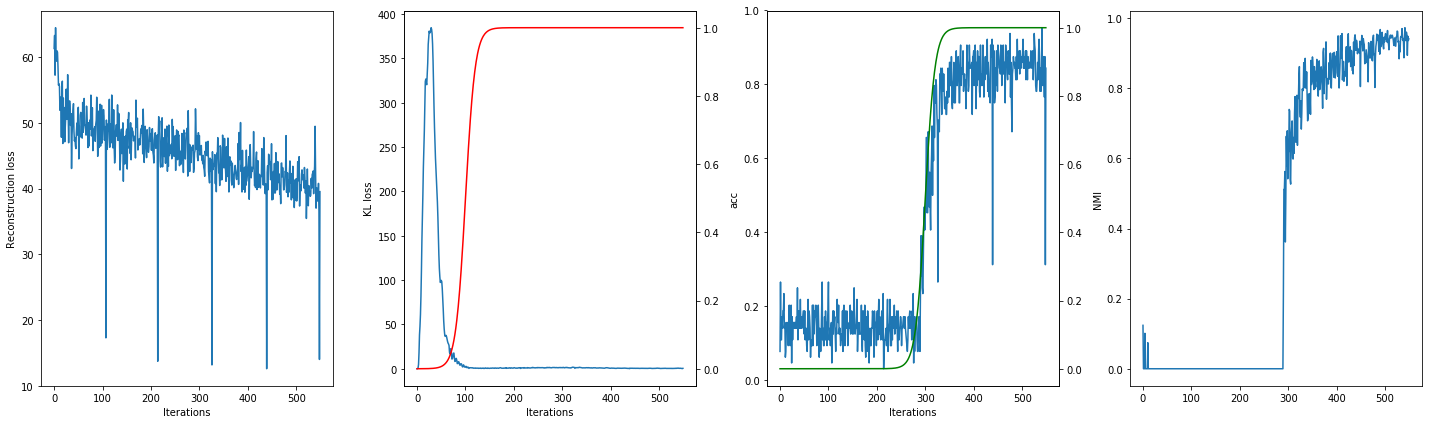

In [43]:
fig, axarr = plt.subplots(1,4, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['NLL_hist']
KL_hist  = run['KL_hist' ]
NMI_hist = run['NMI_hist']
acc_hist = run['acc_hist']
t = np.array(range(len(NLL_hist)))

from train import anneal_fn
anneal_fn = np.vectorize(anneal_fn)
KL_weight = anneal_fn(args.anneal_function, t, args.k1, args.x1)
label_weight = anneal_fn(args.anneal_function, t, args.k2, args.x2)

axarr[0].plot(t, NLL_hist)
axarr[1].plot(t, KL_hist )
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')
axarr[3].plot(t, NMI_hist)

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax2.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
axarr[3].set_ylabel('NMI')

fig.tight_layout()
plt.show()

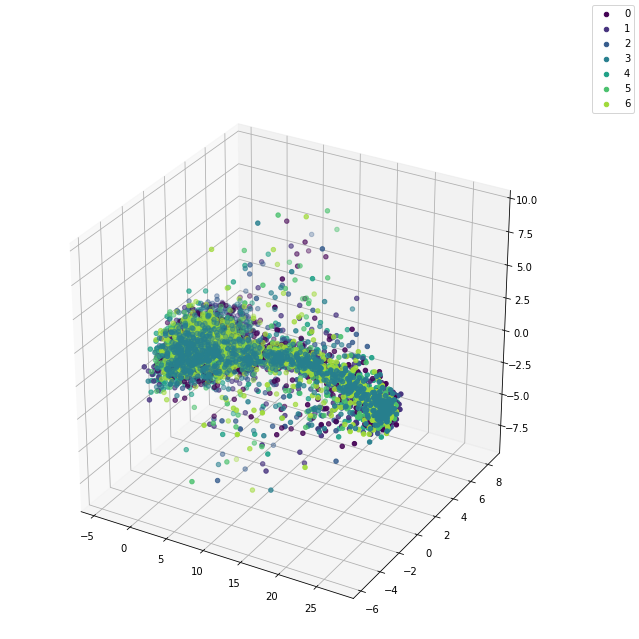

In [33]:
n_per_intent = 1000

latent = run['latent']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

# Embeddings

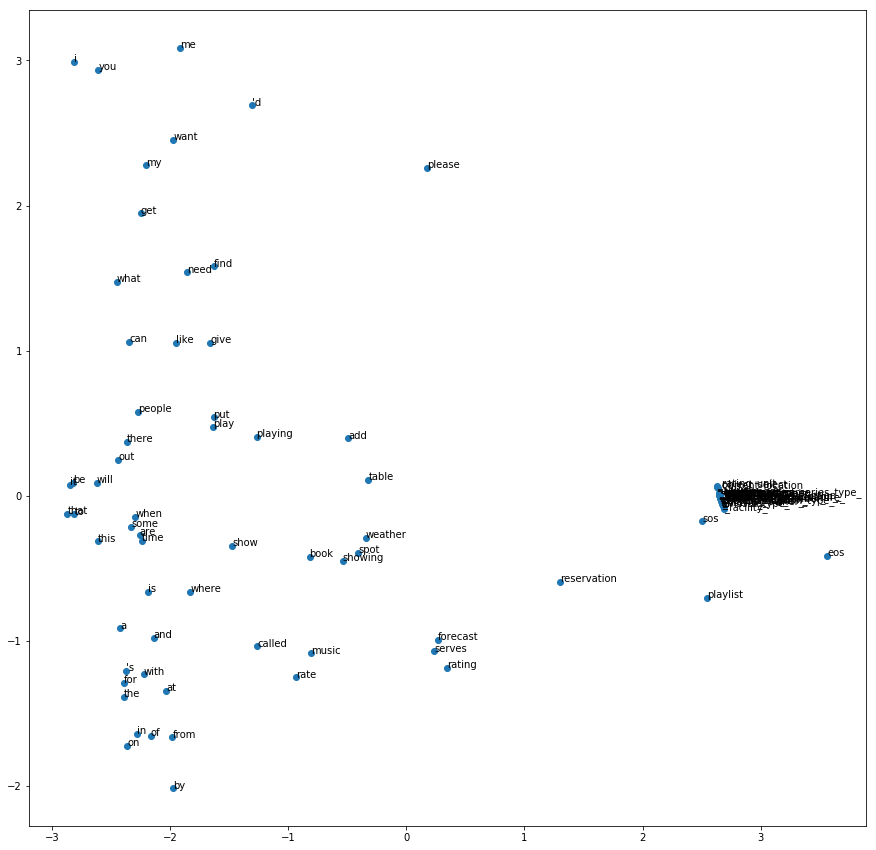

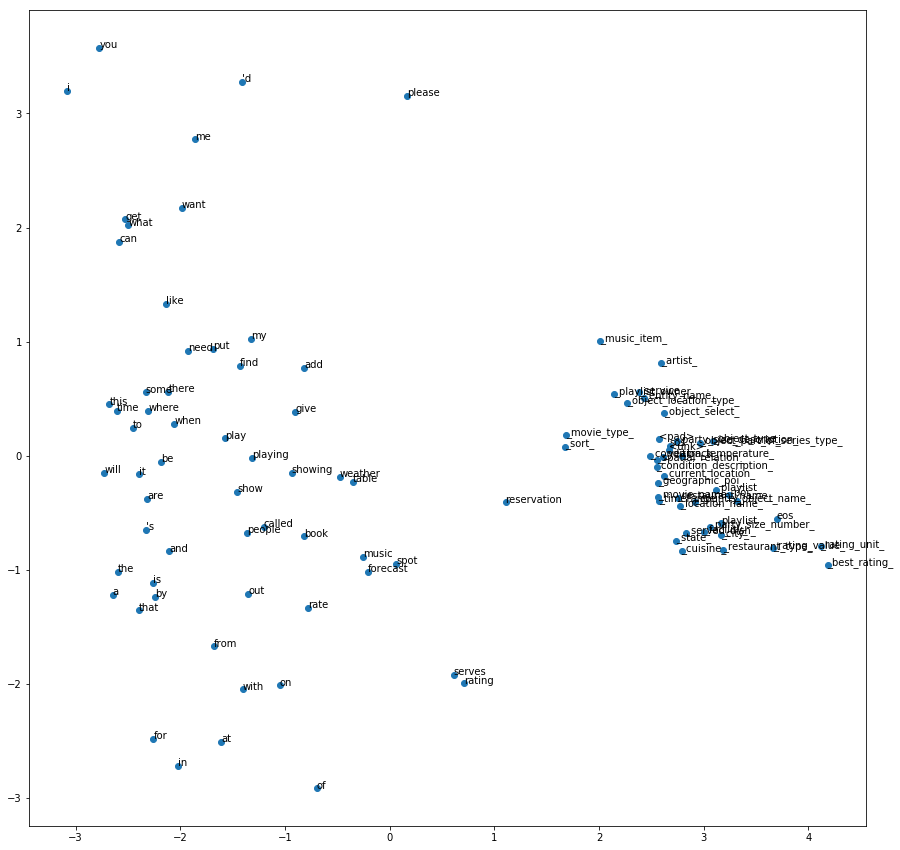

In [75]:
n_start = 0
n_end = 100

words = run['i2w']

from sklearn.decomposition import PCA
for stage in ['before', 'after']:
    plt.figure(figsize=(15,15))
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors)
    plt.scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        plt.annotate(word,xy=(proj[i,0], proj[i,1]))


In [57]:
torch.load('model.pyT')

OrderedDict([('embedding.weight',
              tensor([[ 0.1921, -0.2815,  0.3182,  ...,  0.2181, -0.0855,  0.2457],
                      [-0.0821,  0.0056, -0.2377,  ..., -0.2729, -0.1468, -0.3179],
                      [-0.0185, -0.4712,  0.6809,  ..., -0.1240,  0.6838,  0.2918],
                      ...,
                      [-0.4834, -0.6849,  0.2429,  ..., -0.9180, -0.3549,  0.4394],
                      [-0.0129, -0.0123,  0.1122,  ..., -0.1125,  0.0160,  0.0125],
                      [-0.0924,  0.0281, -0.0924,  ...,  0.0301,  0.0890,  0.0694]])),
             ('encoder_rnn.weight_ih_l0',
              tensor([[-0.1075,  0.3431, -0.4618,  ..., -0.1942, -0.4242, -0.0990],
                      [-0.4843,  0.2732,  0.0377,  ..., -0.0945,  0.0666, -0.2631],
                      [ 0.1756, -0.0753,  0.1541,  ..., -0.0277, -0.4174, -0.0386],
                      ...,
                      [ 0.1054, -0.3737,  0.2265,  ...,  0.0235, -0.2438, -0.1926],
                      [-0.2

# Hyperparameter search

Bidirectional : off
x0 : 100
k : 0.1
num_layers : 1
latent_size : little effect
embed_size : little effect